## Выполнение работы.  

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
from sklearn.metrics import silhouette_score
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('twitchdata.csv')

**Добавление нового атрибута**  
В качестве нового атрибута будет графа темпа роста подписчиков.  
Она отражает процентное соотношение кол-ва новых подписчиков.

In [3]:
df['Growth_Rate'] = df['Followers gained'] / df['Followers'] * 100

**Удаление выбросов**  
Для начала проверим наличие выбросов.

In [4]:
num_columns = df.select_dtypes(include=[np.number]).columns
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

print("ВЫБРОСЫ ПО МЕТОДУ IQR:")
print(" ")
for column in num_columns:
    outliers, lower, upper = detect_outliers_iqr(df, column)
    print(f"{column}: {len(outliers)} выбросов    (границы: [{lower:.2f}, {upper:.2f}])")

ВЫБРОСЫ ПО МЕТОДУ IQR:
 
Watch time(Minutes): 107 выбросов    (границы: [-242635141.88, 839564953.12])
Stream time(minutes): 48 выбросов    (границы: [-28368.75, 243971.25])
Peak viewers: 113 выбросов    (границы: [-33570.25, 80253.75])
Average viewers: 100 выбросов    (границы: [-3535.00, 9779.00])
Followers: 89 выбросов    (границы: [-510132.75, 1305011.25])
Followers gained: 90 выбросов    (границы: [-244800.50, 524689.50])
Views gained: 91 выбросов    (границы: [-8593636.75, 24671001.25])
Growth_Rate: 0 выбросов    (границы: [-40.77, 115.96])


In [5]:
for col in num_columns:
    if col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

print("Выбросы обработаны")

Выбросы обработаны


**Удаление дубликатов**

In [6]:
initial_size = len(df)
df = df.drop_duplicates()
print(f"Удалено дубликатов: {initial_size - len(df)}")

Удалено дубликатов: 0


**Обработка пропущенных значений**

In [7]:
missing_percentage = (df.isnull().sum() / len(df)) * 100
for col, percent in missing_percentage.items():
    if percent > 0:
        print(f"{col}: {percent:.1f}% пропусков")
    else: 
        print(f"{col}: пропуски не обнаружены")

Channel: пропуски не обнаружены
Watch time(Minutes): пропуски не обнаружены
Stream time(minutes): пропуски не обнаружены
Peak viewers: пропуски не обнаружены
Average viewers: пропуски не обнаружены
Followers: пропуски не обнаружены
Followers gained: пропуски не обнаружены
Views gained: пропуски не обнаружены
Partnered: пропуски не обнаружены
Mature: пропуски не обнаружены
Language: пропуски не обнаружены
Growth_Rate: пропуски не обнаружены


**Построение графиков зависимости (сразу с кластерами)**

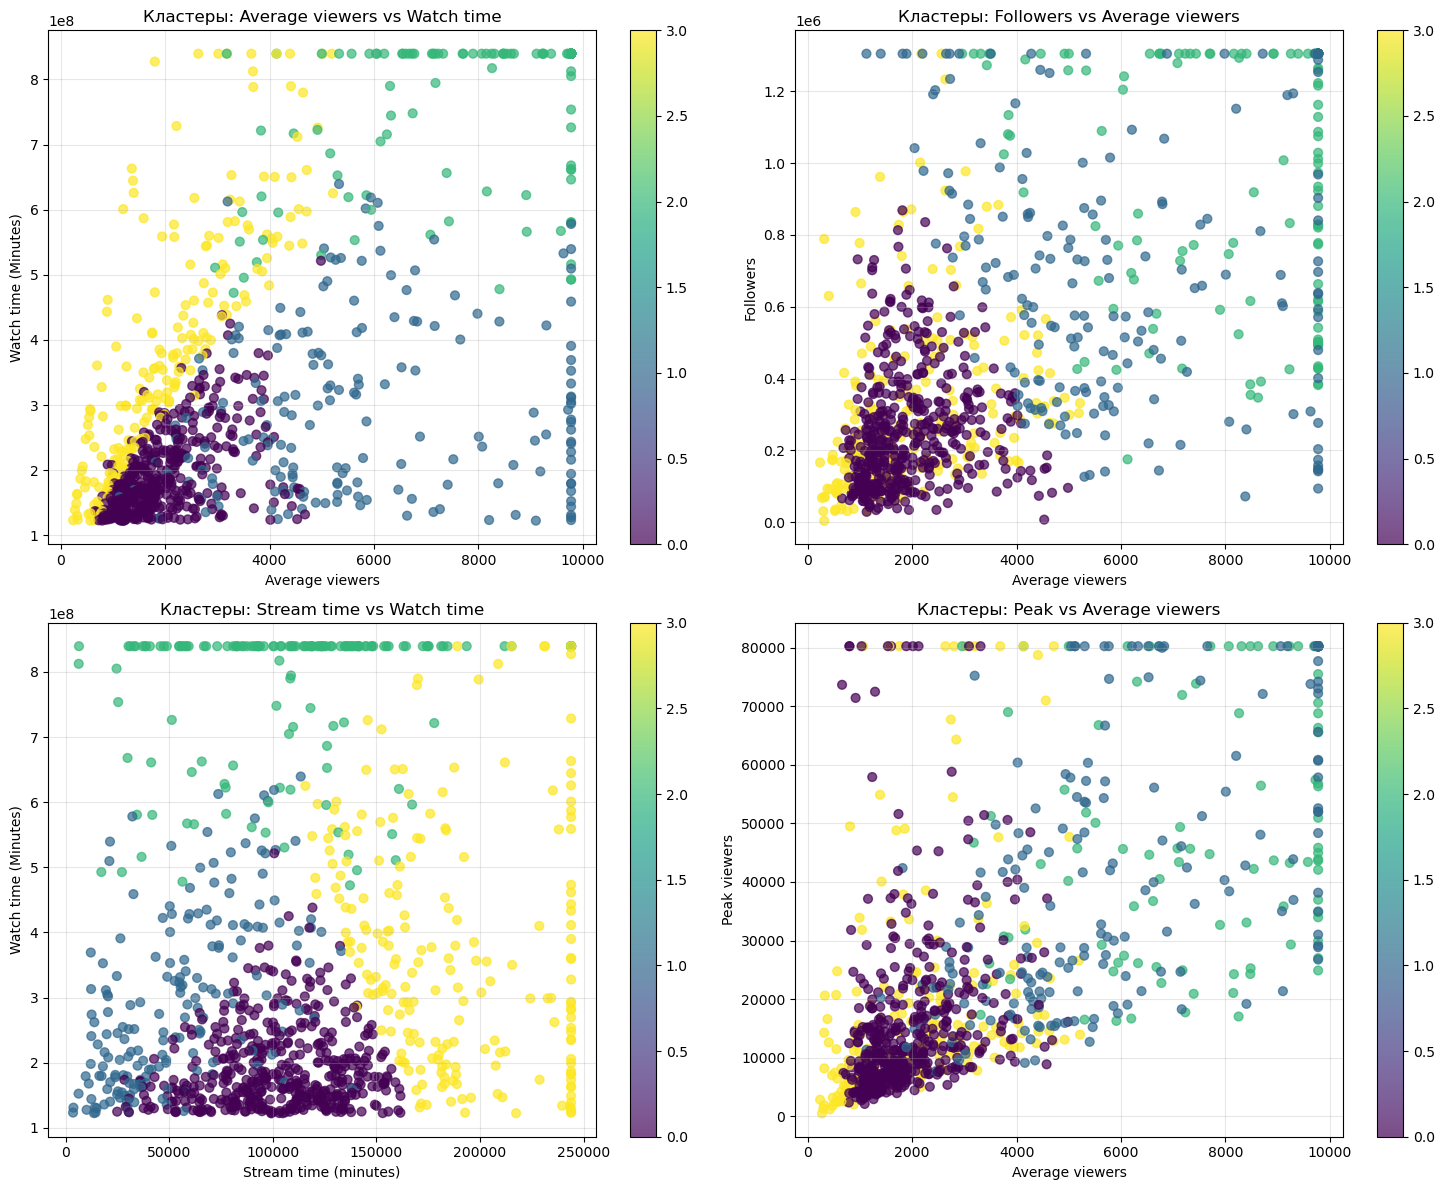

In [8]:
X = df[['Average viewers', 'Watch time(Minutes)', 'Followers', 'Stream time(minutes)']].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

df_clustered = df.copy()
df_clustered['Cluster'] = clusters[:len(df)] 

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

scatter1 = axes[0,0].scatter(df_clustered['Average viewers'], df_clustered['Watch time(Minutes)'], c=df_clustered['Cluster'], cmap='viridis', alpha=0.7, s=40)
axes[0,0].set_xlabel('Average viewers')
axes[0,0].set_ylabel('Watch time (Minutes)')
axes[0,0].set_title('Кластеры: Average viewers vs Watch time')
axes[0,0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0,0])

scatter2 = axes[0,1].scatter(df_clustered['Average viewers'], df_clustered['Followers'], c=df_clustered['Cluster'], cmap='viridis', alpha=0.7, s=40)
axes[0,1].set_xlabel('Average viewers')
axes[0,1].set_ylabel('Followers')
axes[0,1].set_title('Кластеры: Followers vs Average viewers')
axes[0,1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[0,1])

scatter3 = axes[1,0].scatter(df_clustered['Stream time(minutes)'], df_clustered['Watch time(Minutes)'], c=df_clustered['Cluster'], cmap='viridis', alpha=0.7, s=40)
axes[1,0].set_xlabel('Stream time (minutes)')
axes[1,0].set_ylabel('Watch time (Minutes)')
axes[1,0].set_title('Кластеры: Stream time vs Watch time')
axes[1,0].grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=axes[1,0])

scatter4 = axes[1,1].scatter(df_clustered['Average viewers'], df_clustered['Peak viewers'], c=df_clustered['Cluster'], cmap='viridis', alpha=0.7, s=40)
axes[1,1].set_xlabel('Average viewers')
axes[1,1].set_ylabel('Peak viewers')
axes[1,1].set_title('Кластеры: Peak vs Average viewers')
axes[1,1].grid(True, alpha=0.3)
plt.colorbar(scatter4, ax=axes[1,1])

plt.tight_layout()
plt.show()

In [9]:
for cluster_id in sorted(df_clustered['Cluster'].unique()):
    cluster_data = df_clustered[df_clustered['Cluster'] == cluster_id]
    avg_viewers = cluster_data['Average viewers'].mean()
    followers = cluster_data['Followers'].mean()
    
    print(f"\nКластер {cluster_id} ({len(cluster_data)} стримеров):")
    print(f"  Средние зрители: {avg_viewers:,.0f}")
    print(f"  Подписчики: {followers:,.0f}")


Кластер 0 (463 стримеров):
  Средние зрители: 1,929
  Подписчики: 254,971

Кластер 1 (183 стримеров):
  Средние зрители: 5,851
  Подписчики: 694,868

Кластер 2 (146 стримеров):
  Средние зрители: 8,202
  Подписчики: 1,017,617

Кластер 3 (208 стримеров):
  Средние зрители: 2,036
  Подписчики: 317,449


**Метод KMeans**

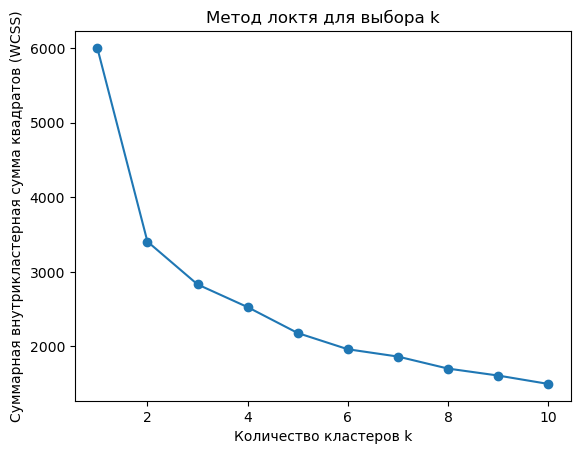

In [23]:
features = ['Watch time(Minutes)', 'Stream time(minutes)', 
           'Average viewers', 'Followers', 'Peak viewers', 'Followers gained']
X = df[features].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Количество кластеров k')
plt.ylabel('Суммарная внутрикластерная сумма квадратов (WCSS)')
plt.title('Метод локтя для выбора k')
plt.show()

k_optimal = 4
kmeans_final = KMeans(n_clusters=k_optimal, random_state=42)
clusters = kmeans_final.fit_predict(X_scaled)

df['Cluster'] = clusters

Примем 4 за оптимальное кол-во кластеров

In [26]:
kmeans_final = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X_scaled)

df['Cluster'] = np.nan
df.loc[X.index, 'Cluster'] = clusters

print(f"Оптимальное число кластеров: {k_optimal}")
print("\nРаспределение по кластерам:")
print(df['Cluster'].value_counts().sort_index())


Оптимальное число кластеров: 4

Распределение по кластерам:
Cluster
0.0    461
1.0    143
2.0    277
3.0    119
Name: count, dtype: int64


1000

In [30]:
len(kmeans.labels_)
df['cluster'] = kmeans.labels_
df.head()

,Channel,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Followers gained,Views gained,Partnered,Mature,Language,Growth_Rate,Cluster,cluster
0,xQcOW,8.395650e+08,215250.00,80253.75,9779.0,1305011.25,524689.5,24671001.25,True,False,English,53.439641,1.0,1
1,summit1g,8.395650e+08,211845.00,80253.75,9779.0,1305011.25,524689.5,24671001.25,True,False,English,25.803050,1.0,1
2,Gaules,8.395650e+08,243971.25,80253.75,9779.0,1305011.25,524689.5,24671001.25,True,True,Portuguese,57.918009,1.0,1
3,ESL_CSGO,8.395650e+08,243971.25,80253.75,7714.0,1305011.25,524689.5,24671001.25,True,False,English,17.845698,1.0,1
4,Tfue,8.395650e+08,123660.00,80253.75,9779.0,1305011.25,524689.5,24671001.25,True,False,English,23.139573,1.0,3


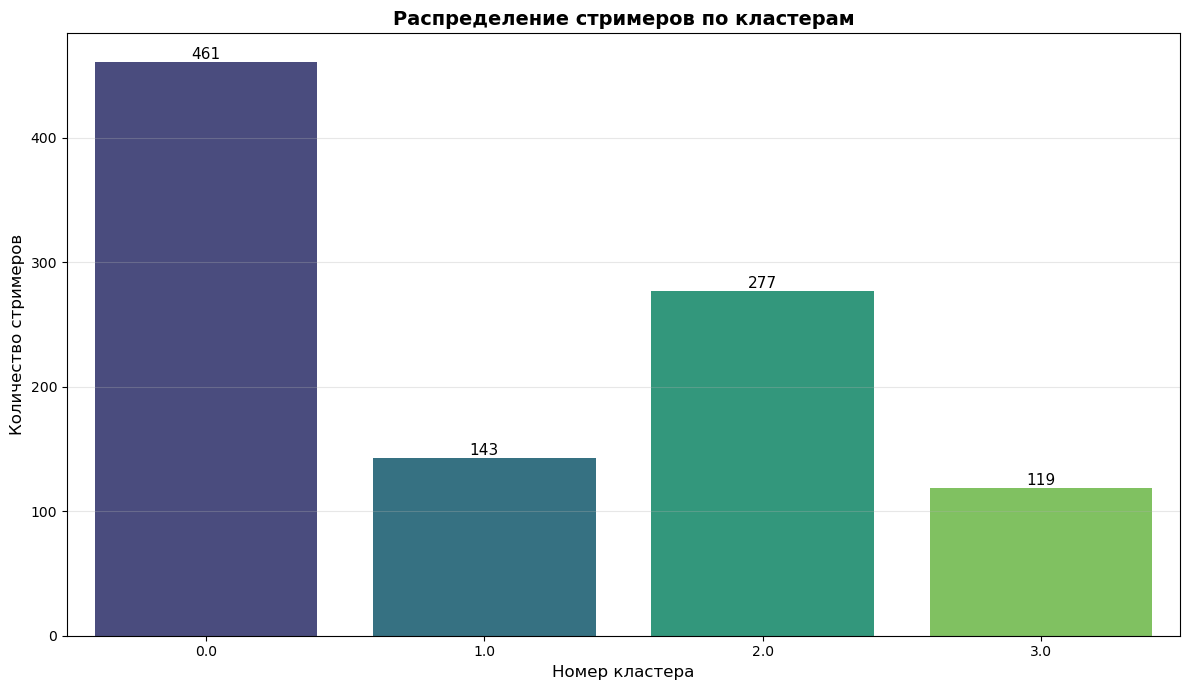

In [33]:
plt.figure(figsize=(12,7))
cluster_counts = df['Cluster'].value_counts().sort_index()
axis = sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')

axis.set_xlabel("Номер кластера", fontsize=12)
axis.set_ylabel("Количество стримеров", fontsize=12)
axis.set_title("Распределение стримеров по кластерам", fontsize=14, fontweight='bold')

for i, value in enumerate(cluster_counts.values):
    axis.text(i, value + 0.1, str(value), ha='center', va='bottom', fontsize=11)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Выводы  
Во время выполнения работы я смогла добавить новый производный атрибут "Темпы роста", который позволил оценить количественные показатели работы стримеров. Провела очистку данных, обработав выбросы, и проверила на наличие дубликатов и пропусков. Построила матрицу scatter plot для выявления взаимосвязей между ключевыми показателями, визуализировала четкие кластеры стримеров с различными аспектами успеха на платформе. Успешно применила метод KMeans кластеризации для сегментации стримеров, а также смогла определить оптимальное количество кластеров. 